In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm


# === Load and Process Data ===
def load_data(path):
    return pd.read_csv(path)


def encode_smiles(smiles, bitsize=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(bitsize)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=bitsize))


def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "MW": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
        "HBondDonors": Descriptors.NumHDonors(mol),
        "HBondAcceptors": Descriptors.NumHAcceptors(mol),
        "TPSA": Descriptors.TPSA(mol)
    }


def get_atomic_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = []
    for atom in mol.GetAtoms():
        atom_type_one_hot = [0] * 100
        atom_num = atom.GetAtomicNum()
        if atom_num < 100:
            atom_type_one_hot[atom_num] = 1

        formal_charge = [atom.GetFormalCharge()]
        hybridization_type = [0] * 5
        hyb_map = {
            Chem.rdchem.HybridizationType.SP: 0,
            Chem.rdchem.HybridizationType.SP2: 1,
            Chem.rdchem.HybridizationType.SP3: 2,
            Chem.rdchem.HybridizationType.SP3D: 3,
            Chem.rdchem.HybridizationType.SP3D2: 4
        }
        idx = hyb_map.get(atom.GetHybridization(), None)
        if idx is not None:
            hybridization_type[idx] = 1

        features = (
            atom_type_one_hot
            + formal_charge
            + hybridization_type
            + [int(atom.GetIsAromatic())]
            + [atom.GetDegree()]
            + [atom.GetTotalNumHs()]
        )
        atom_features.append(features)

    return pd.DataFrame(atom_features).mean(axis="rows")


def prepare_features(data):
    fingerprints = [encode_smiles(smi) for smi in data["SMILES"]]
    descriptors = [compute_descriptors(smi) for smi in data["SMILES"]]
    atomic_features = [get_atomic_features(smi) for smi in tqdm(data["SMILES"])]

    features = pd.DataFrame(fingerprints)
    features.columns = [f"F{i}" for i in features.columns]
    features = pd.concat([features, pd.DataFrame(descriptors), pd.DataFrame(atomic_features)], axis=1)
    return features


def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"R2 Score: {r2:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")
    return model, X_test, y_test, y_pred


def plot_results(y_test, y_pred, r2, mse, rmse):
    plt.scatter(y_test, y_pred, color="black")
    plt.xlabel("True Tg")
    plt.ylabel("Predicted Tg")
    plt.title("True vs Predicted Tg")

    z = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, np.poly1d(z)(y_test), color="red")

    text = f"R2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}"
    plt.text(min(y_test), max(y_pred), text, fontsize=12, bbox=dict(facecolor="white", alpha=0.5))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def test_on_smiles(model, smiles_list):
    test_data = []
    for smi in smiles_list:
        fp = encode_smiles(smi)
        desc = compute_descriptors(smi)
        atom_feat = get_atomic_features(smi)
        combined = np.concatenate([fp, list(desc.values()), atom_feat])
        test_data.append(combined)
    return model.predict(np.array(test_data))


[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:26] DEPRECATION WARNING: please use MorganGenerator
[12:11:27] DEPRECATION WARNING: please use MorganGenerator
[12:11:27] DEPRECATION WARNING: please use MorganGenerat

R2 Score: 0.88, MSE: 1423.77, RMSE: 37.73


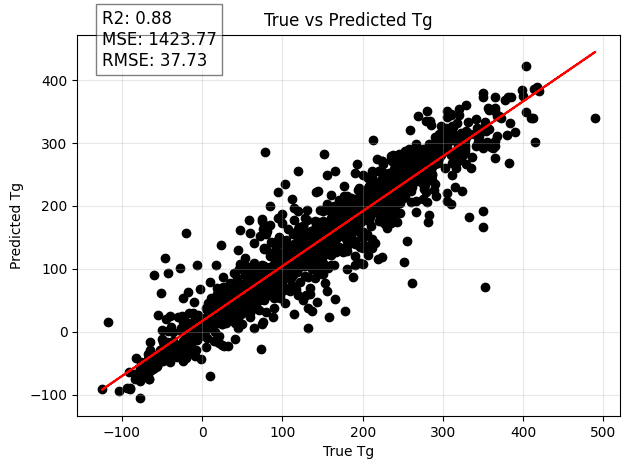

[12:11:56] DEPRECATION WARNING: please use MorganGenerator
[12:11:56] DEPRECATION WARNING: please use MorganGenerator


array([ 73.04826 , 100.769646], dtype=float32)

In [2]:
# === Main Execution ===
DATA_PATH = "./data/D1/tg_raw.csv"
data = load_data(DATA_PATH)
features = prepare_features(data)
processed_data = pd.concat([data, features], axis=1).dropna(subset=["tg"]).reset_index(drop=True)

X = processed_data.drop(columns=["SMILES", "tg"])
y = processed_data["tg"]

model, X_test, y_test, y_pred = train_model(X, y)
plot_results(y_test, y_pred, r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)))

# Example: Predict Tg on new SMILES
new_smiles = ["C=C(C)C", "ClC(Cl)=C"]
predicted_tgs = test_on_smiles(model, new_smiles)
predicted_tgs